# Project: Energy Demand Forecasting Using LSTM Neural Networks
### Description:
This project builds an LSTM-based deep learning model to forecast household energy consumption using historical power usage data. 

The time series is preprocessed with resampling and normalization, and the model is tuned to improve accuracy in predicting short-term energy demand.
- Framework: TensorFlow / Keras  
- Architecture:  LSTM 
- Dataset: CSV file (`household_power_consumption.txt`)   https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption
- Goal: Predicting short-term energy demand for a household.

In [33]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

In [34]:
# reda data, displaying data shape and first 5 rows
data = pd.read_csv("household_power_consumption.txt", sep=";", low_memory=False, na_values="?")
print(f"Data shape: {data.shape}")
data.head()

Data shape: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [35]:
# Combine Date and Time columns
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True, format='%d/%m/%Y %H:%M:%S')

# Drop original Date and Time columns
data = data.drop(columns=['Date', 'Time'])

# Set datetime as index
data = data.set_index('datetime')

data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [36]:
# display data summary
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


There are 2M+ rows containing data as floating point values

In [37]:
# Keep only Global_active_power 
df = data[['Global_active_power']]

# Resample to hourly to reduce data size and generalize more
df = df.resample('h').mean()

# Fill missing values with interpolation
df = df.interpolate()

print(f"Data shape: {df.shape}")
df.head()

Data shape: (34589, 1)


,Global_active_power
datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


We left from 2M+ rows to 34k+

## Data Preprocessing

In [38]:
# convert data to numpy array
data_array = df["Global_active_power"].values
# reshape array to (num_samples, 1)
data_array = data_array.reshape(-1, 1)

# scale values
scaler = MinMaxScaler()
data_array = scaler.fit_transform(data_array)

data_array[:5]

array([[0.63681623],
       [0.54504495],
       [0.50900588],
       [0.48854974],
       [0.45559722]])

#### Create Sequence for LSTM from data

In [39]:
# define function to create sequence
def create_sequences(data, period_size=24):
    """Function gets an array and a desired period_size as input and returns sequences of the array split by the peroid size.
       default period size is 24, for daily.
    """
    X, y = [], []
    for i in range(len(data) - period_size):
        X.append(data[i:i+period_size])
        y.append(data[i+period_size])
    return np.array(X), np.array(y)

In [40]:
# create sequences
X, y = create_sequences(data_array)

# final shape
print("X shape:", X.shape) 
print("y shape:", y.shape) 

X shape: (34565, 24, 1)
y shape: (34565, 1)


### Split data into training and testing sets

In [41]:
# Full dataset size
total_samples = len(X)

# Split indices
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

# Create splits 
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")


Train: (24195, 24, 1)
Val:   (5184, 24, 1)
Test:  (5186, 24, 1)


## Build and Train Model

In [42]:
# define model architecture
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# compile model
lstm_model.compile(loss="mse", optimizer=Adam(0.001))
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [43]:
# set early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
757/757 [==============================] - 5s 6ms/step - loss: 0.0119 - val_loss: 0.0069
Epoch 2/50
757/757 [==============================] - 3s 4ms/step - loss: 0.0099 - val_loss: 0.0064
Epoch 3/50
757/757 [==============================] - 3s 4ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 4/50
757/757 [==============================] - 3s 3ms/step - loss: 0.0092 - val_loss: 0.0059
Epoch 5/50
757/757 [==============================] - 3s 3ms/step - loss: 0.0090 - val_loss: 0.0059
Epoch 6/50
757/757 [==============================] - 3s 3ms/step - loss: 0.0089 - val_loss: 0.0059
Epoch 7/50
757/757 [==============================] - 3s 4ms/step - loss: 0.0089 - val_loss: 0.0059
Epoch 8/50
757/757 [==============================] - 3s 4ms/step - loss: 0.0088 - val_loss: 0.0060
Epoch 9/50
757/757 [==============================] - 3s 3ms/step - loss: 0.0088 - val_loss: 0.0058
Epoch 10/50
757/757 [==============================] - 3s 3ms/step - loss: 0.0088 - val_loss: 0.0058

## Evaluate model

In [44]:
# Predict on test set
y_pred = lstm_model.predict(X_test)

# Inverse transform target 
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Compute metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE:  {mae:.2f} kW")
print(f"R²:   {r2:.3f}")


163/163 [==============================] - 1s 1ms/step
MAE:  0.33 kW
R²:   0.520


## Plot Training Curves

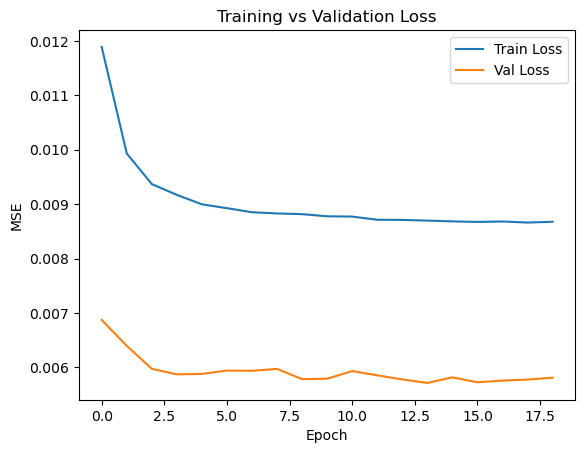

In [45]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


## Attempt Hyper Parameter tuning

In [27]:
# define hyper model
def build_model(hp):
    model = Sequential()

    use_second_lstm = hp.Boolean('use_second_lstm')

    # First LSTM layer
    model.add(LSTM(
        units=hp.Int('units_1', min_value=32, max_value=128, step=16),
        return_sequences=use_second_lstm,  # Only True if we're stacking another LSTM
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))

    # Optional second LSTM layer
    if use_second_lstm:
        model.add(LSTM(
            units=hp.Int('units_2', min_value=32, max_value=128, step=16),
            return_sequences=False
        ))
    
    # Dropout
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output
    model.add(Dense(1))  

    # Compile
    model.compile(
        optimizer=Adam(hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    
    return model



In [18]:
# set up tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # how many models to try
    executions_per_trial=1, 
    directory='lstm_tuning',
    project_name='energy_forecast'
)

# run search
tuner.search(X_train, y_train, 
             epochs=20, 
             validation_data=(X_test, y_test),
             batch_size=32)


Trial 20 Complete [00h 02m 16s]
val_loss: 0.0057358816266059875

Best val_loss So Far: 0.005631648004055023
Total elapsed time: 00h 40m 06s


In [21]:
# get best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print(f"Best units_1: {best_hps.get('units_1')}")
print(f"Best units_2: {best_hps.get('units_2')}")
print(f"Best dropout: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('lr')}")


Best units_1: 112
Best units_2: 112
Best dropout: 0.1
Best learning rate: 0.01


Fine tuning didn't improve model performance much as best loss wasn't very different from what we already had

In [22]:
# retrain with the best model
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
757/757 [==============================] - 7s 7ms/step - loss: 0.0086 - val_loss: 0.0059
Epoch 2/50
757/757 [==============================] - 4s 6ms/step - loss: 0.0085 - val_loss: 0.0057
Epoch 3/50
757/757 [==============================] - 4s 6ms/step - loss: 0.0085 - val_loss: 0.0058
Epoch 4/50
757/757 [==============================] - 4s 5ms/step - loss: 0.0084 - val_loss: 0.0057
Epoch 5/50
757/757 [==============================] - 4s 6ms/step - loss: 0.0084 - val_loss: 0.0060
Epoch 6/50
757/757 [==============================] - 4s 6ms/step - loss: 0.0084 - val_loss: 0.0060
Epoch 7/50
757/757 [==============================] - 4s 6ms/step - loss: 0.0085 - val_loss: 0.0057
Epoch 8/50
757/757 [==============================] - 4s 6ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 9/50
757/757 [==============================] - 4s 6ms/step - loss: 0.0083 - val_loss: 0.0056
Epoch 10/50
757/757 [==============================] - 4s 6ms/step - loss: 0.0083 - val_loss: 0.0056

In [23]:
# Predict on test set
y_pred = best_model.predict(X_test)

# Inverse transform target 
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Compute metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE:  {mae:.2f} kW")
print(f"R²:   {r2:.3f}")


163/163 [==============================] - 1s 3ms/step
MAE:  0.33 kW
R²:   0.532


## Feature Engineering for Multiple Feature Prediction

In [6]:
df.head()

,Global_active_power
datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


In [7]:
# Create new time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Optional: One-hot encode if you want
# df = pd.get_dummies(df, columns=['hour', 'day_of_week', 'month'], drop_first=True)
df.head()

,Global_active_power,hour,day_of_week,month,is_weekend
datetime,,,,,
2006-12-16 17:00:00,4.222889,17,5,12,1
2006-12-16 18:00:00,3.632200,18,5,12,1
2006-12-16 19:00:00,3.400233,19,5,12,1
2006-12-16 20:00:00,3.268567,20,5,12,1
2006-12-16 21:00:00,3.056467,21,5,12,1


## Form Sequences

In [8]:
def create_multivariate_sequences(data, period_size, target_col_index):
    X, y = [], []
    for i in range(len(data) - period_size):
        X.append(data[i:i+period_size])
        y.append(data[i+period_size][target_col_index])
    return np.array(X), np.array(y)


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values)


# Create sequences with time features
X, y = create_multivariate_sequences(data=data_scaled, period_size=24, target_col_index=0)

X.shape, y.shape

((34565, 24, 5), (34565,))

## Split data

In [9]:
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")


Train: (27652, 24, 5)
Val:   (6913, 24, 5)


## Build and fit Model

In [ ]:
# define model architecture. Using same architecture as before to see effect of feature engineering. Though we're using more data
lstm_model2 = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# compile model
lstm_model2.compile(loss="mse", optimizer=Adam(0.001))
lstm_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17920     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


In [12]:
# set early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = lstm_model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
865/865 [==============================] - 7s 4ms/step - loss: 0.0129 - val_loss: 0.0067
Epoch 2/50
865/865 [==============================] - 3s 4ms/step - loss: 0.0098 - val_loss: 0.0064
Epoch 3/50
865/865 [==============================] - 3s 4ms/step - loss: 0.0092 - val_loss: 0.0062
Epoch 4/50
865/865 [==============================] - 3s 4ms/step - loss: 0.0088 - val_loss: 0.0071
Epoch 5/50
865/865 [==============================] - 4s 4ms/step - loss: 0.0086 - val_loss: 0.0060
Epoch 6/50
865/865 [==============================] - 4s 4ms/step - loss: 0.0085 - val_loss: 0.0058
Epoch 7/50
865/865 [==============================] - 4s 4ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 8/50
865/865 [==============================] - 3s 4ms/step - loss: 0.0082 - val_loss: 0.0063
Epoch 9/50
865/865 [==============================] - 3s 3ms/step - loss: 0.0081 - val_loss: 0.0058
Epoch 10/50
865/865 [==============================] - 3s 4ms/step - loss: 0.0081 - val_loss: 0.0057

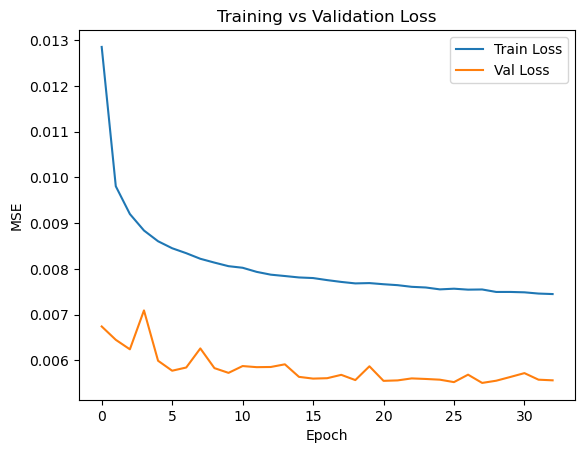

In [13]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [22]:
# Use previous 48 hours for prediction
X, y = create_multivariate_sequences(data=data_scaled, period_size=48, target_col_index=0)

X.shape, y.shape

((34541, 48, 5), (34541,))

In [23]:
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [24]:
# define model architecture. Using same architecture as before to see effect of feature engineering. Though we're using more data
lstm_model3 = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# compile model
lstm_model3.compile(loss="mse", optimizer=Adam(0.001))
lstm_model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17920     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


In [25]:
# set early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = lstm_model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
864/864 [==============================] - 6s 5ms/step - loss: 0.0148 - val_loss: 0.0070
Epoch 2/50
864/864 [==============================] - 4s 5ms/step - loss: 0.0102 - val_loss: 0.0066
Epoch 3/50
864/864 [==============================] - 4s 5ms/step - loss: 0.0094 - val_loss: 0.0062
Epoch 4/50
864/864 [==============================] - 4s 5ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 5/50
864/864 [==============================] - 4s 5ms/step - loss: 0.0086 - val_loss: 0.0058
Epoch 6/50
864/864 [==============================] - 4s 5ms/step - loss: 0.0085 - val_loss: 0.0061
Epoch 7/50
864/864 [==============================] - 4s 5ms/step - loss: 0.0083 - val_loss: 0.0060
Epoch 8/50
864/864 [==============================] - 4s 5ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 9/50
864/864 [==============================] - 4s 5ms/step - loss: 0.0082 - val_loss: 0.0058
Epoch 10/50
864/864 [==============================] - 4s 5ms/step - loss: 0.0081 - val_loss: 0.0060

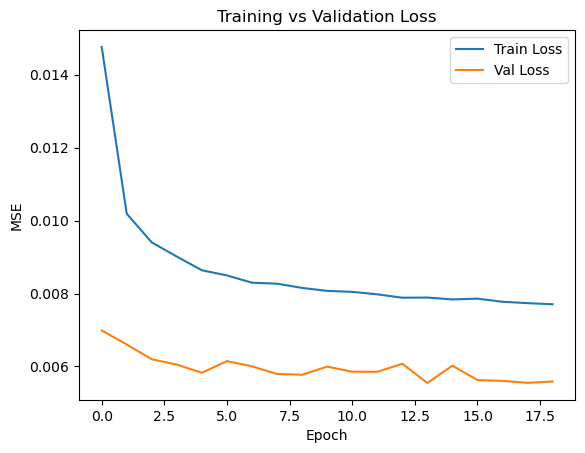

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


### Attempt hyper parameter tuning

In [30]:
# set up tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # how many models to try
    executions_per_trial=1, 
    directory='lstm_tuning',
    project_name='energy_forecast',
    overwrite=True
)

# run search
tuner.search(X_train, y_train, 
             epochs=20, 
             validation_data=(X_val, y_val),
             batch_size=32)


Trial 20 Complete [00h 03m 06s]
val_loss: 0.005963109899312258

Best val_loss So Far: 0.005423416383564472
Total elapsed time: 00h 48m 17s


 looks like this didn't provide parameters to improve the model performance a lot more.

## Predict Future daily usage based on previous 48h data

In [14]:
# form sequences
def create_multi_step_sequences(data, period_size, prediction_size, target_col_index):
    X, y = [], []
    for i in range(len(data) - period_size - prediction_size):
        seq_x = data[i:i+period_size]
        seq_y = data[i+period_size:i+period_size+prediction_size, target_col_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X, y = create_multi_step_sequences(data_scaled, period_size=48, prediction_size=24, target_col_index=0)

print("X shape:", X.shape)  # e.g., (samples, 48, num_features)
print("y shape:", y.shape)  # e.g., (samples, 24)


X shape: (34517, 48, 5)
y shape: (34517, 24)


## Split data

In [16]:
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

print(f"Train: {X_train.shape, y_train.shape}")
print(f"Val:   {X_val.shape, y_val.shape}")

Train: ((27613, 48, 5), (27613, 24))
Val:   ((6904, 48, 5), (6904, 24))


## Build and Fit Model

In [ ]:
# define model architecture. 
lstm_model4 = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(24)
])

# compile model
lstm_model4.compile(loss="mse", optimizer=Adam(0.001))
lstm_model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               68608     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 71,704
Trainable params: 71,704
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set early stopping
early_stop = EarlyStopping(patience=8, restore_best_weights=True)

history = lstm_model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
863/863 [==============================] - 6s 6ms/step - loss: 0.0163 - val_loss: 0.0091
Epoch 2/50
863/863 [==============================] - 5s 6ms/step - loss: 0.0134 - val_loss: 0.0088
Epoch 3/50
863/863 [==============================] - 5s 6ms/step - loss: 0.0128 - val_loss: 0.0085
Epoch 4/50
863/863 [==============================] - 5s 6ms/step - loss: 0.0123 - val_loss: 0.0086
Epoch 5/50
863/863 [==============================] - 5s 6ms/step - loss: 0.0120 - val_loss: 0.0087
Epoch 6/50
863/863 [==============================] - 5s 6ms/step - loss: 0.0118 - val_loss: 0.0084
Epoch 7/50
863/863 [==============================] - 5s 5ms/step - loss: 0.0116 - val_loss: 0.0086
Epoch 8/50
863/863 [==============================] - 5s 6ms/step - loss: 0.0113 - val_loss: 0.0088
Epoch 9/50
863/863 [==============================] - 5s 6ms/step - loss: 0.0111 - val_loss: 0.0091
Epoch 10/50
863/863 [==============================] - 5s 6ms/step - loss: 0.0107 - val_loss: 0.0088